Autor: so jae woo    
Data src :  qesg news / 28 cat / 본문 포함.     
Summary : Tf-IDF 데이터로 UMAP 기반 차원축소 진행   

In [102]:
import pickle
import joblib
import os
import pandas as pd
import cuml
from cuml import UMAP as umap
import numpy as np
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import seaborn as sns

import matplotlib
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
font_location = '../segoeui.ttf'
font_location = '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf'
# font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
# font_location = 'D:/NanumGothic.ttf' # for 회사컴
fprop = fm.FontProperties(fname=font_location)

/tmp/ipykernel_1718/3945114048.py:14: MatplotlibDeprecationWarning: The get_fontconfig_fonts function was deprecated in Matplotlib 3.5 and will be removed two minor releases later.
  fm.get_fontconfig_fonts()


In [104]:
import matplotlib
import matplotlib.font_manager

[f.fname for f in matplotlib.font_manager.fontManager.ttflist]

['/opt/conda/envs/rapids/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf',
 '/opt/conda/envs/rapids/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf',
 '/opt/conda/envs/rapids/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf',
 '/opt/conda/envs/rapids/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf',
 '/opt/conda/envs/rapids/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf',
 '/opt/conda/envs/rapids/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf',
 '/opt/conda/envs/rapids/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf',
 '/opt/conda/envs/rapids/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf',
 '/opt/conda/envs/rapids/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf',
 '/opt/conda/envs/rapids/lib/python3.9/site-packa

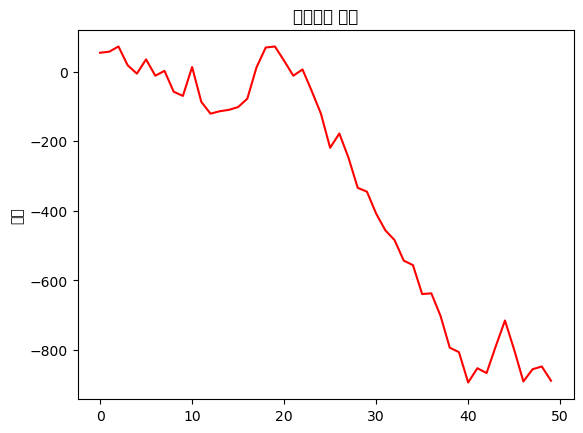

In [103]:
import matplotlib.pyplot as plt
data = np.random.randint(-100, 100, 50).cumsum()
plt.plot(range(50), data, 'r')
plt.title('가격변동 추이')
plt.ylabel('가격')
plt.show()

In [75]:
pd.unique(dfraw.y)

array(['주주가치보호', '소유구조', '사업장안전및보건', '내부통제/투명성', '계열회사와의거래', '이사회구성과운영',
       '인적자원관리', '사회공헌', 'ESG거버넌스', '제품/서비스', '에너지및온실가스', '감사기구', '공급망관리',
       '소비자보호', '지역사회영향', '기타', '인권', '공정거래', '이익배분', '대기오염', '환경관리체계',
       '자원순환', '공시', '생물다양성', '수질오염', '화학물질배출', '친환경제품/서비스개발', '토양오염',
       '기타오염'], dtype=object)

In [76]:
dfraw = pd.read_parquet('./data/df_qesg28_final.pq')
dfraw = dfraw.loc[dfraw.y != '제외']
dfraw = dfraw.loc[dfraw.y != '기타']

tfidfv= joblib.load('./data/tfidfv_cat_v07.joblib') 

/opt/conda/envs/rapids/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.24.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.24.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [90]:
# metric
dist_list = ['euclidean',
             'manhattan',
             #'cityblock',
             'braycurtis',
             'canberra',
             'chebyshev',
             'correlation',
             'cosine',
             'dice',
             'hamming',
             'jaccard',
             'kulsinski',
             'mahalanobis',
             #'matching',
             'minkowski',
             'rogerstanimoto',
             'russellrao',
             'seuclidean',
             'sokalmichener',
             'sokalsneath',
             #'sqeuclidean',
             'yule',
             'wminkowski']
n_neighbor_list = np.arange(120 , 420 , 20)
min_dist_list = np.arange(0.1 , 1.0 , 0.1)

In [89]:
def plot_umap_unsupervised(xs,ys , issupervised ,n_neighbors , min_dist , dist, figsize = (8,6), save_dir = None):
    umap_model = umap(n_neighbors=n_neighbors,
                          min_dist=min_dist,
                          n_components = 2,
                          metric=dist )
    if issupervised:
        embedding = umap_model.fit_transform(xs,ys)
    else:
        embedding = umap_model.fit_transform(xs)
    print('-'*100)
    print(dist , n_neighbors , min_dist)

    fig , ax = plt.subplots(1,1,figsize = figsize)

    #sns.scatterplot(embedding[:,0] , embedding[:,1] , hue = ys , ax = ax)
     # color 의 수는 class 수와 같게 맞춘다. 
    color = sns.color_palette("colorblind", 6)
    grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)
    grid.set(xscale="log", yscale="log")
    if save_dir is not None:
        plt.savefig( save_dir + '/{}_{}_{}.png'.format(dist , str(n_neighbors) ,str(min_dist)))
    plt.show()
    return embedding

   



def umap_combination_unsupervised(xs, ys = None, dist_list=dist_list, n_neighbor_list=n_neighbor_list, min_dist_list=min_dist_list,
                                                                        issupervised = False , figsize = (8,6) , save_dir = None):
    for dist in dist_list:
        for nn in n_neighbor_list:
            for md in min_dist_list:
                try:
                    plot_umap_unsupervised(xs,ys , issupervised ,nn , md , dist , figsize , save_dir)
                except Exception as e:
                    print(e)
                    continue

## 데이터 준비

In [79]:
feature = tfidfv.transform(dfraw.contents_clean).toarray()
y = dfraw.y.values
le = LabelEncoder()
ys = le.fit_transform(y)

In [93]:
le.classes_

array(['ESG거버넌스', '감사기구', '계열회사와의거래', '공급망관리', '공시', '공정거래', '기타오염',
       '내부통제/투명성', '대기오염', '사업장안전및보건', '사회공헌', '생물다양성', '소비자보호', '소유구조',
       '수질오염', '에너지및온실가스', '이사회구성과운영', '이익배분', '인권', '인적자원관리', '자원순환',
       '제품/서비스', '주주가치보호', '지역사회영향', '친환경제품/서비스개발', '토양오염', '화학물질배출',
       '환경관리체계'], dtype=object)

# Start

/tmp/ipykernel_1718/49556981.py:13: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=y, ax=ax, palette=color,alpha=0.6)
/tmp/ipykernel_1718/49556981.py:16: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.
  plt.savefig( './img' + '/00000.png'.format('euclidean' , str(10) ,str(0.3)))
/tmp/ipykernel_1718/49556981.py:16: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  plt.savefig( './img' + '/00000.png'.format('euclidean' , str(10) ,str(0.3)))
/tmp/ipykernel_1718/49556981.py:16: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from current font.
  plt.savefig( './img' + '/00000.png'.format('euclidean' , str(10) ,str(0.3)))
/tmp/ipykernel_1718/49556981.py:16: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from current font.
  plt.savefig( './img' + '/00000.png'.for

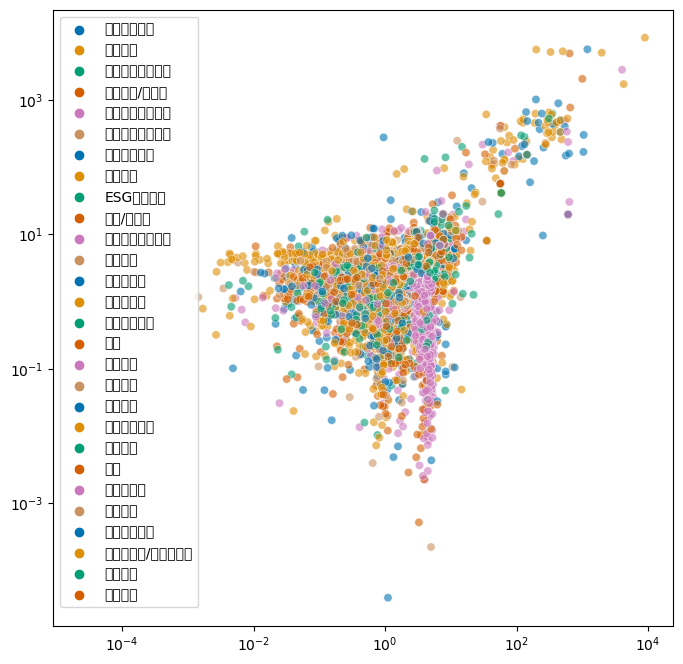

In [99]:
xs = feature
ys = ys
umap_model = umap(n_neighbors=100,
                          min_dist=0.4,
                          n_components = 2,
                          metric='cosine' )

#embedding = umap_model.fit_transform(xs,ys)
embedding = umap_model.fit_transform(xs)

fig , ax = plt.subplots(1,1,figsize = (8,8))
color = sns.color_palette("colorblind", 6)
grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=y, ax=ax, palette=color,alpha=0.6)
grid.set(xscale="log", yscale="log")
#grid.savefig( './img' + '/{}_{}_{}.png'.format('euclidean' , str(10) ,str(0.3)))
plt.savefig( './img' + '/00000.png'.format('euclidean' , str(10) ,str(0.3)))
plt.show()

----------------------------------------------------------------------------------------------------
euclidean 120 0.1


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


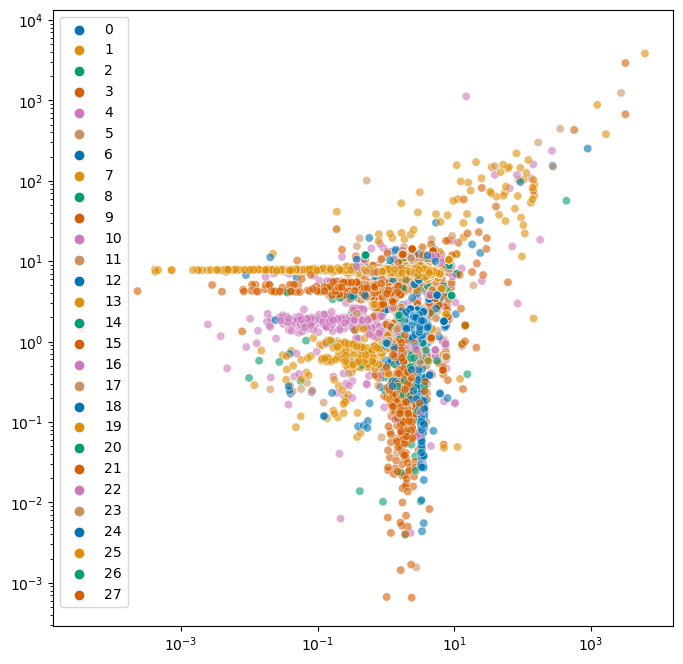

----------------------------------------------------------------------------------------------------
euclidean 120 0.4


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


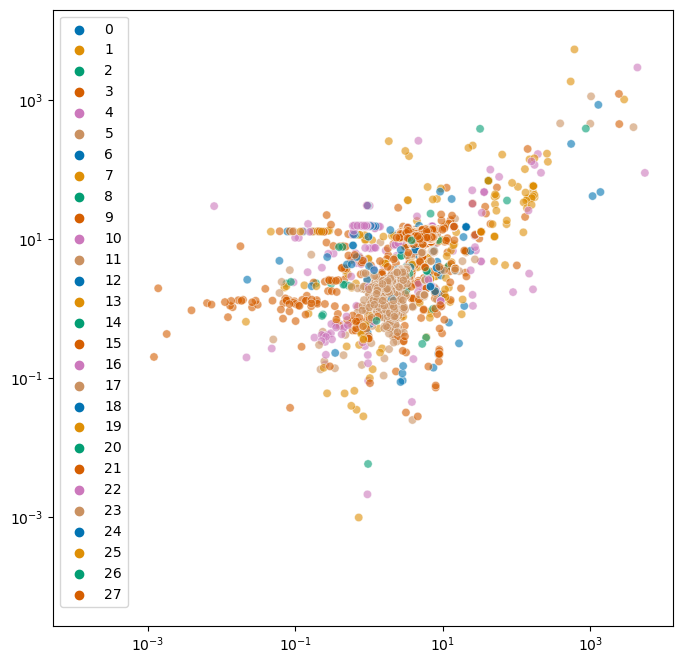

----------------------------------------------------------------------------------------------------
euclidean 120 0.7000000000000001


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


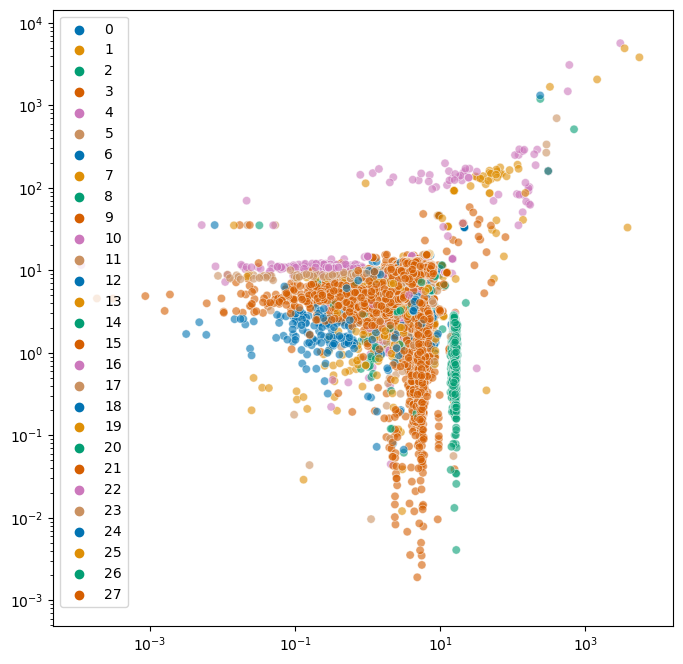

----------------------------------------------------------------------------------------------------
euclidean 140 0.1


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


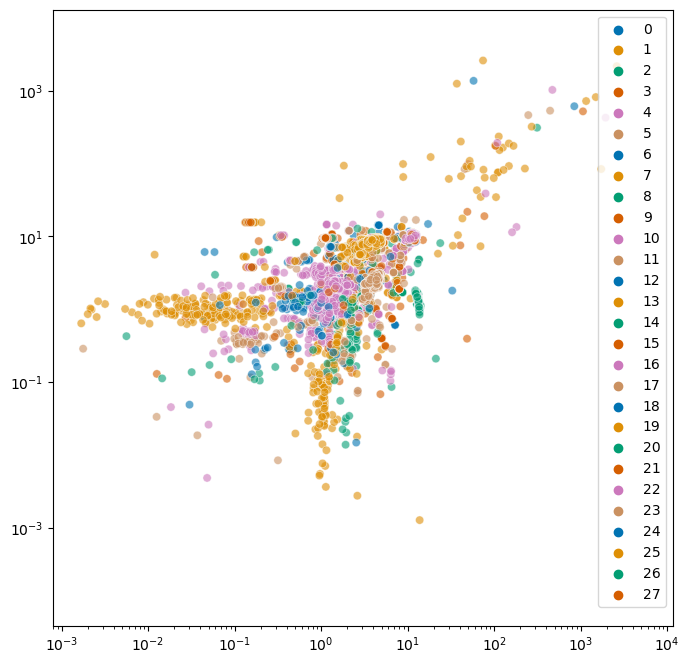

----------------------------------------------------------------------------------------------------
euclidean 140 0.4


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


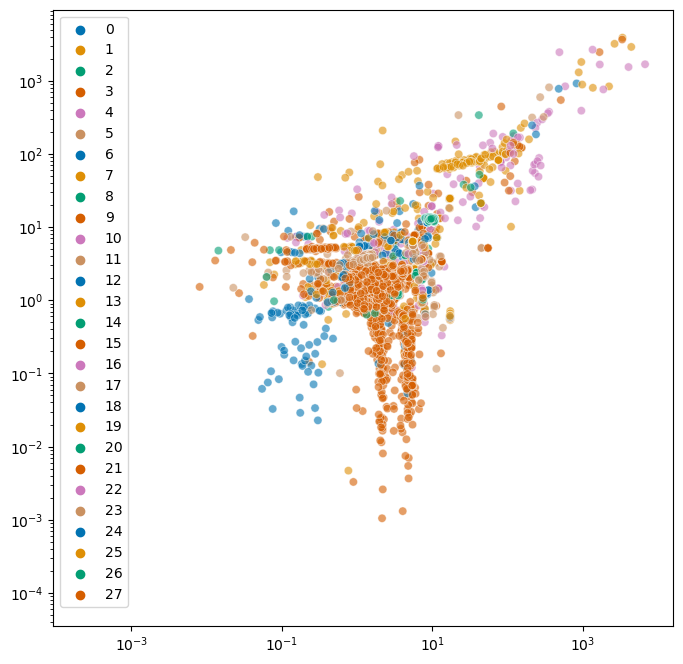

----------------------------------------------------------------------------------------------------
euclidean 140 0.7000000000000001


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


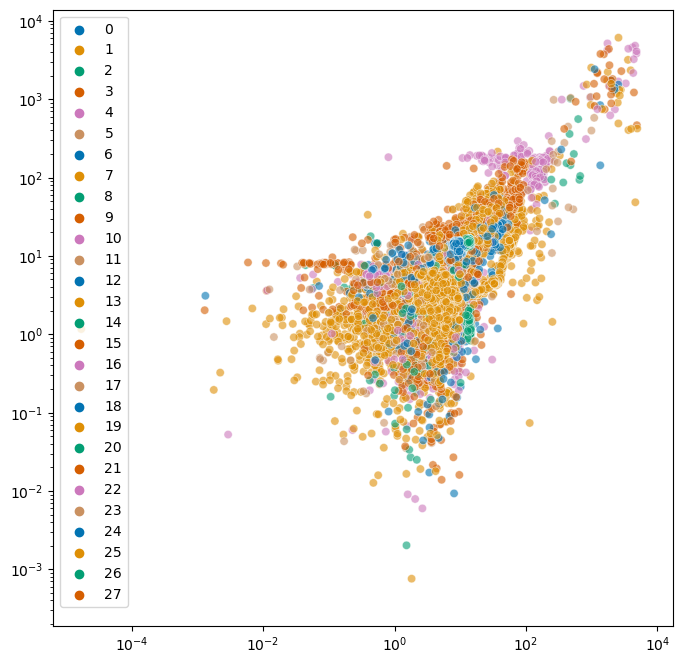

----------------------------------------------------------------------------------------------------
euclidean 160 0.1


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


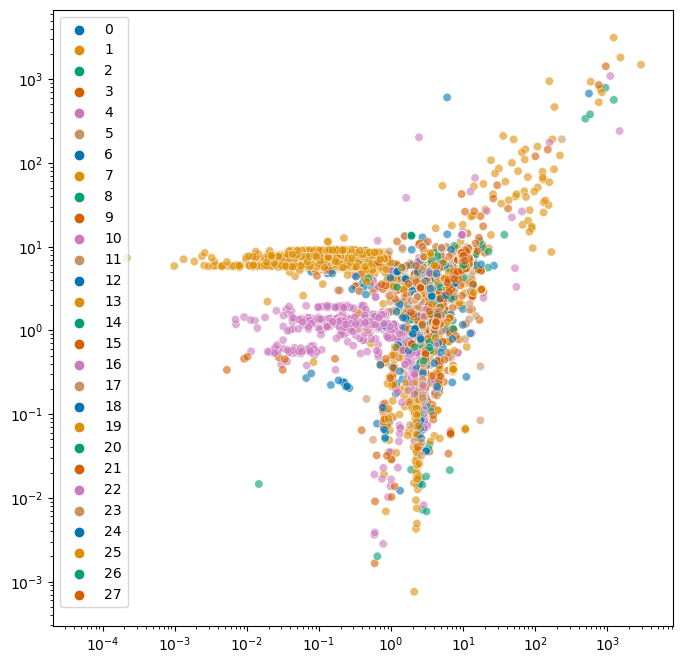

----------------------------------------------------------------------------------------------------
euclidean 160 0.4


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


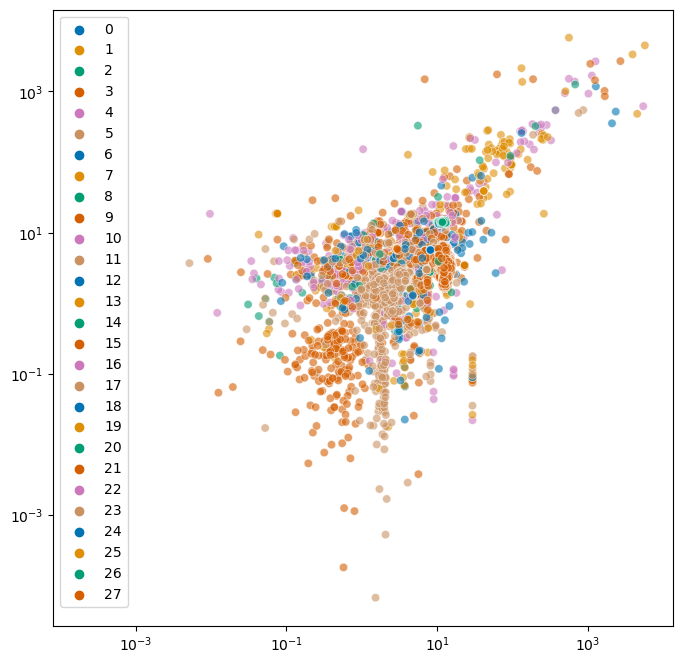

----------------------------------------------------------------------------------------------------
euclidean 160 0.7000000000000001


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


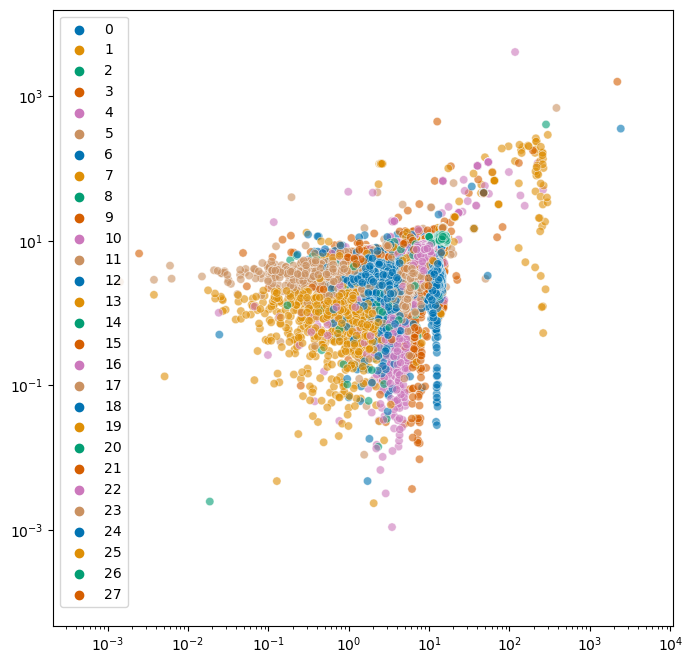

----------------------------------------------------------------------------------------------------
euclidean 180 0.1


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


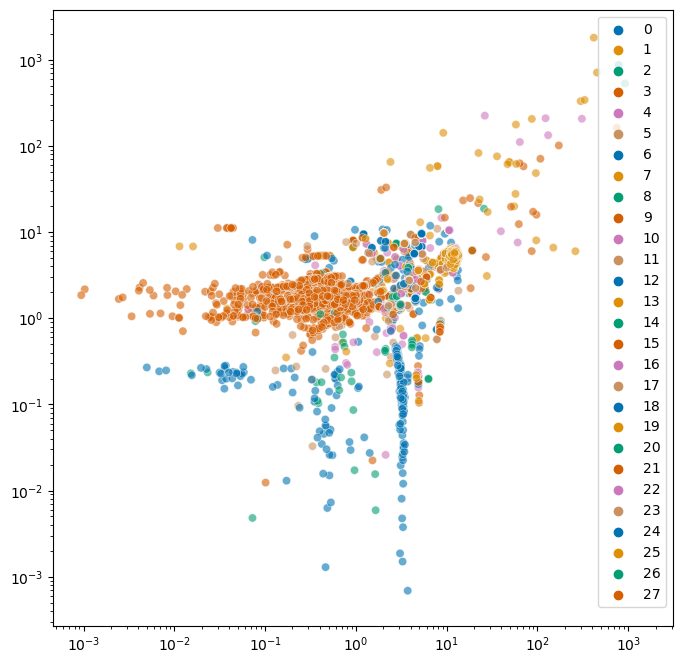

----------------------------------------------------------------------------------------------------
euclidean 180 0.4


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


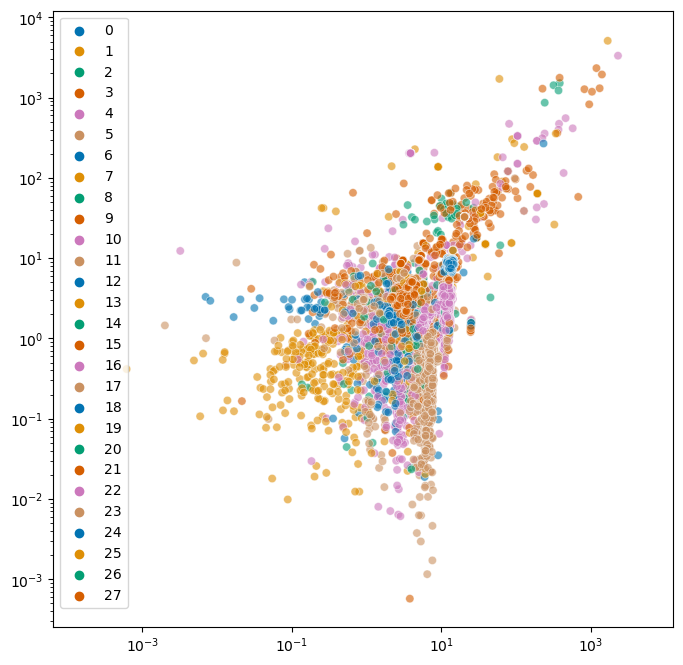

----------------------------------------------------------------------------------------------------
euclidean 180 0.7000000000000001


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


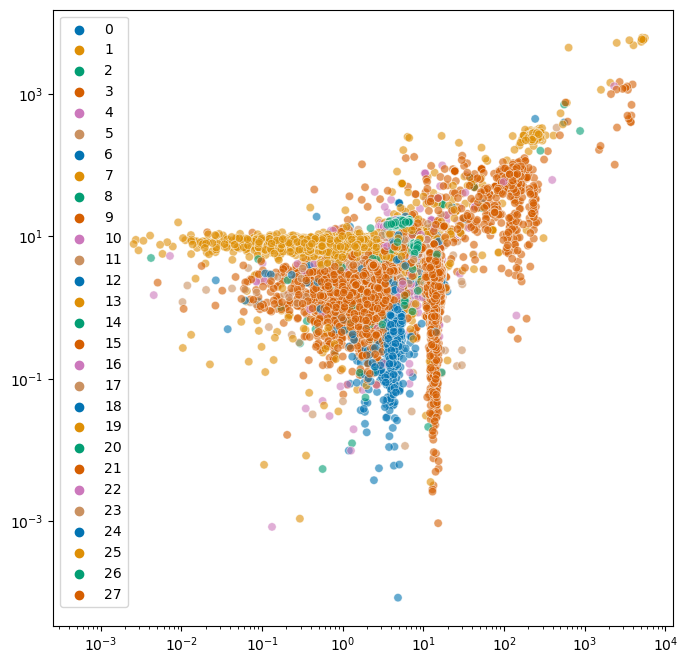

----------------------------------------------------------------------------------------------------
euclidean 200 0.1


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


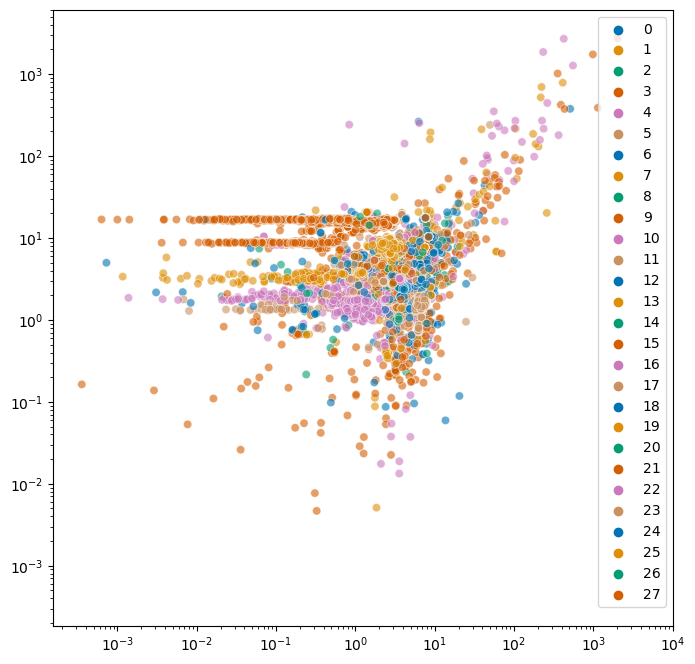

----------------------------------------------------------------------------------------------------
euclidean 200 0.4


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


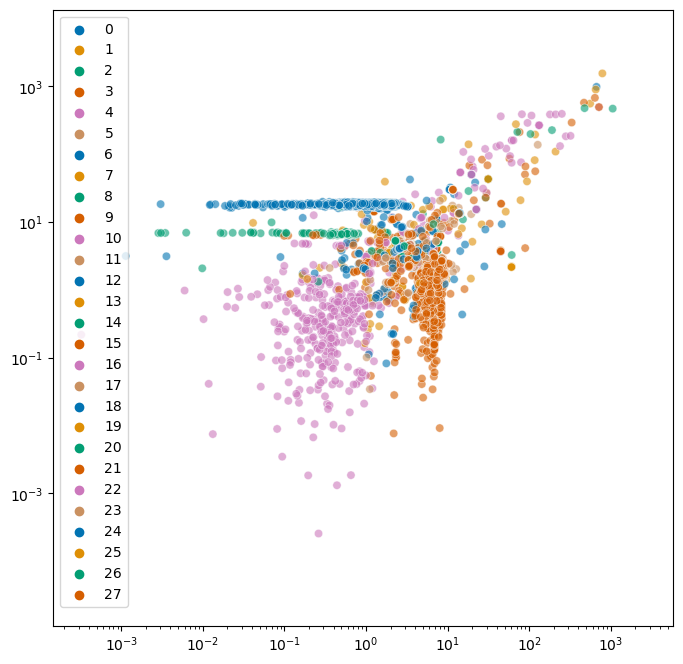

----------------------------------------------------------------------------------------------------
euclidean 200 0.7000000000000001


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


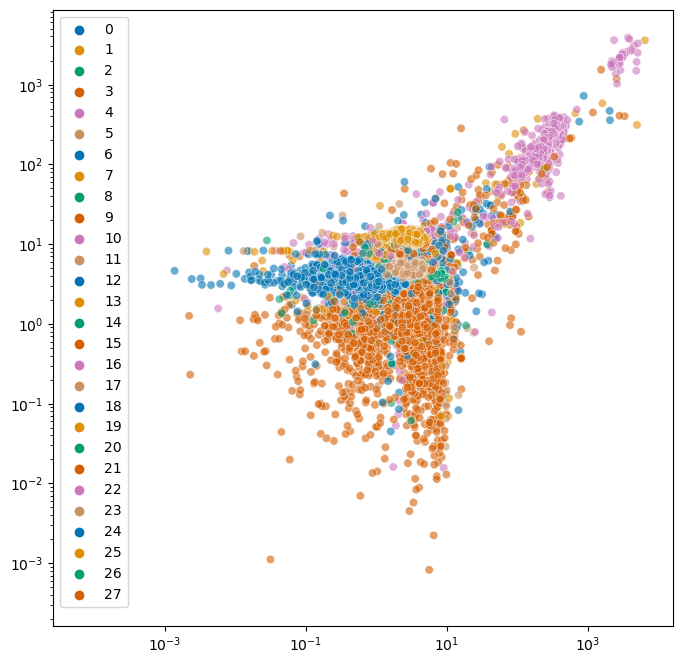

----------------------------------------------------------------------------------------------------
euclidean 220 0.1


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


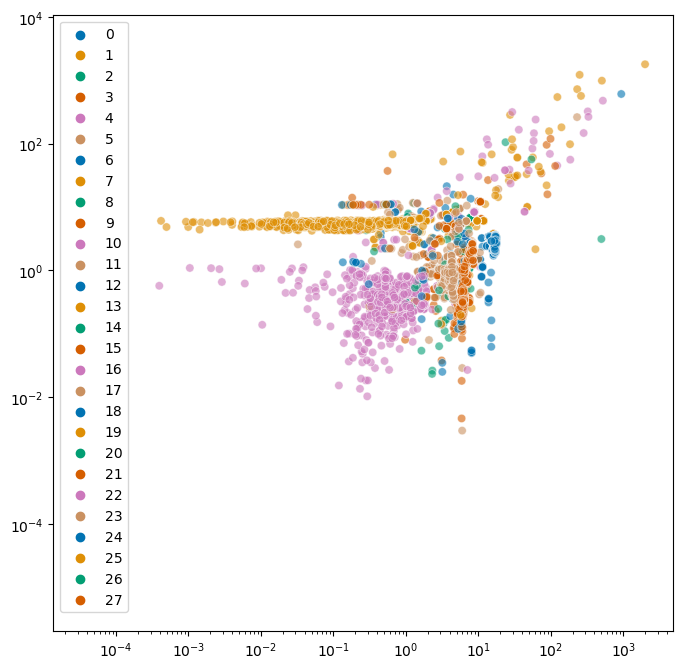

----------------------------------------------------------------------------------------------------
euclidean 220 0.4


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


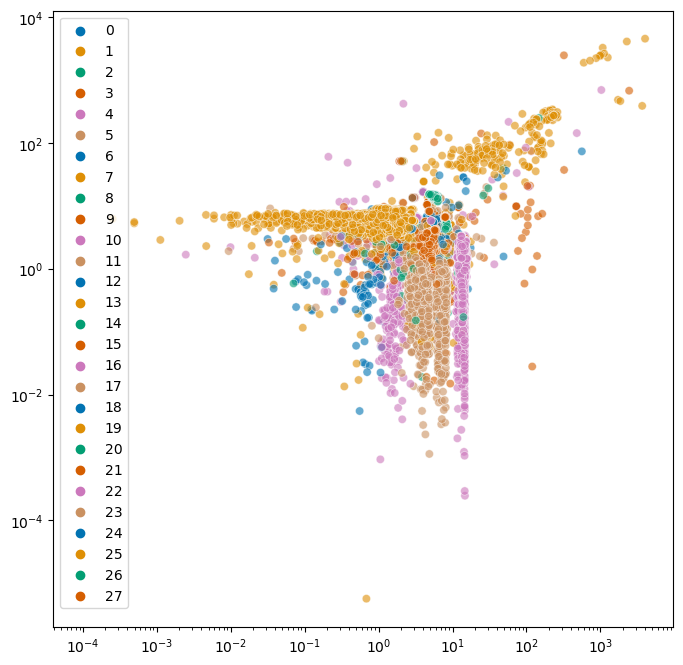

----------------------------------------------------------------------------------------------------
euclidean 220 0.7000000000000001


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


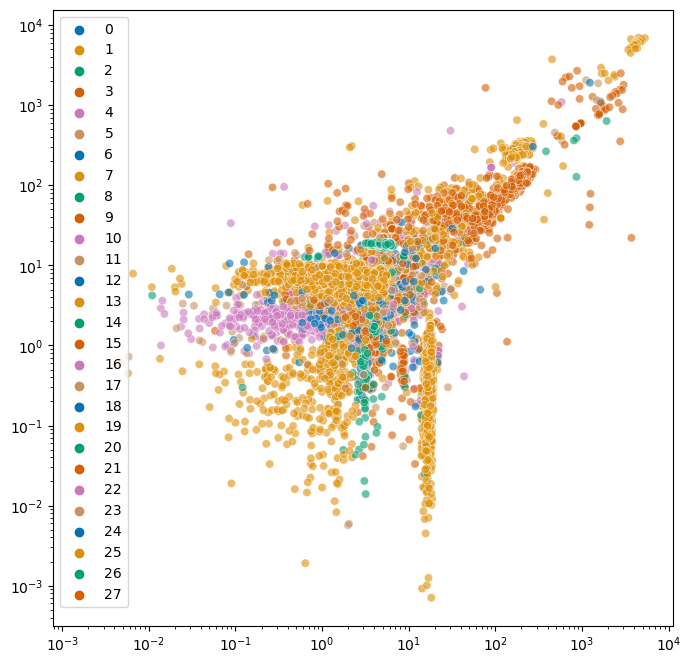

----------------------------------------------------------------------------------------------------
euclidean 240 0.1


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


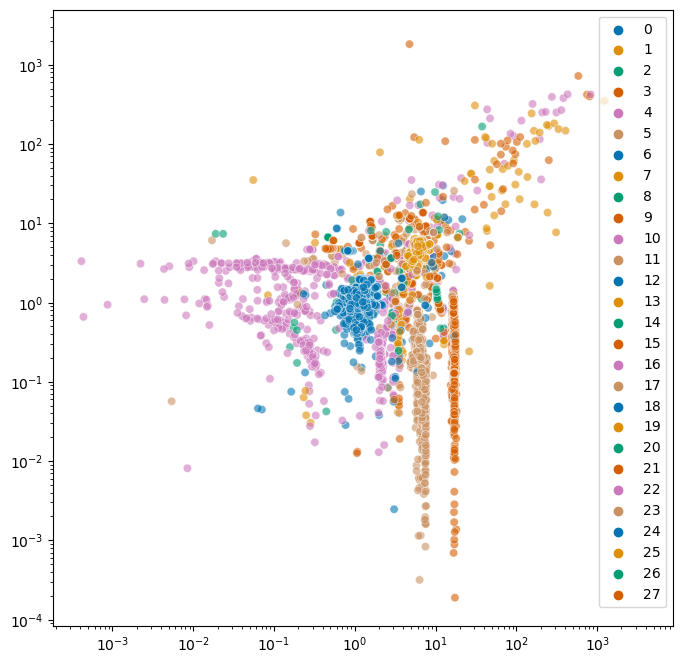

----------------------------------------------------------------------------------------------------
euclidean 240 0.4


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


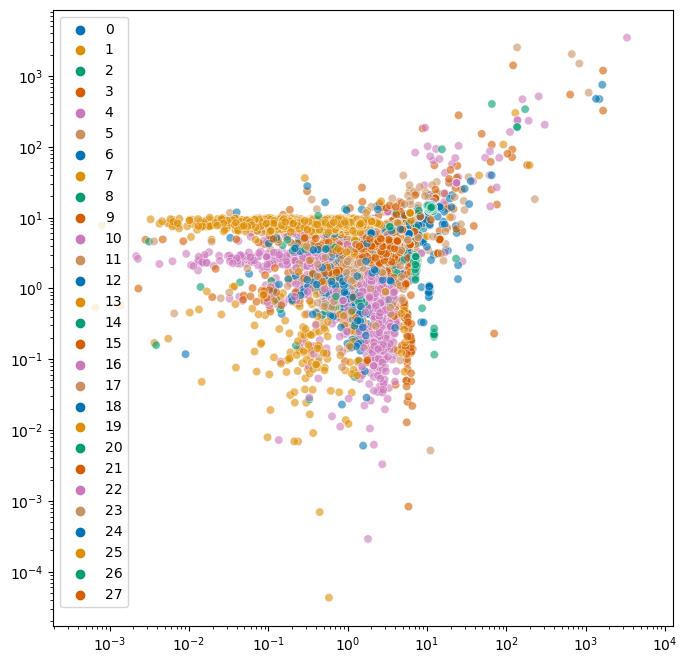

----------------------------------------------------------------------------------------------------
euclidean 240 0.7000000000000001


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


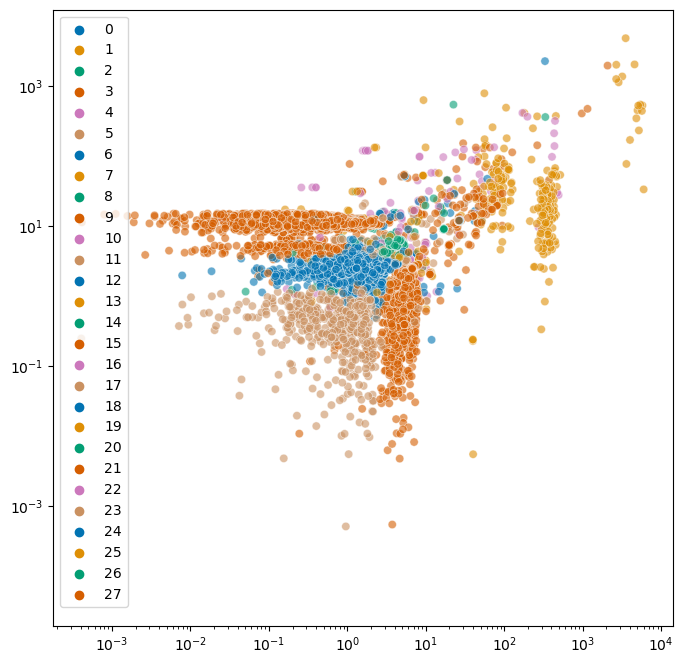

----------------------------------------------------------------------------------------------------
euclidean 260 0.1


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


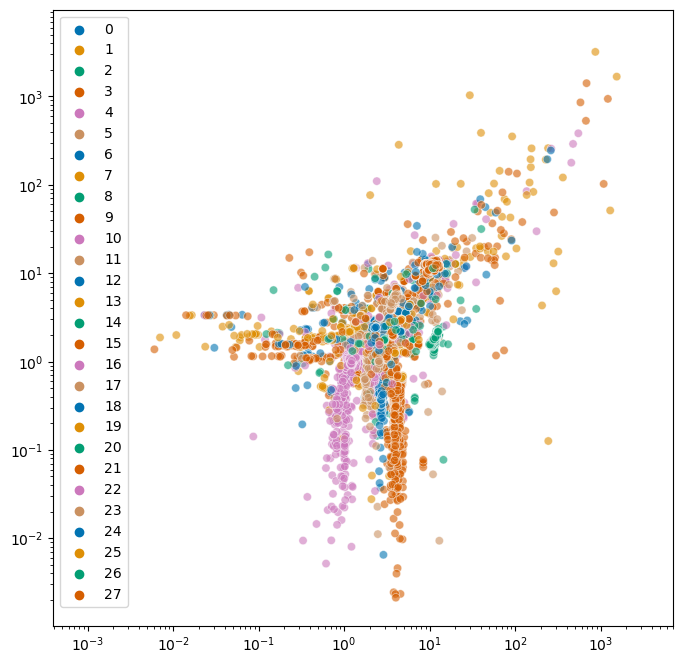

----------------------------------------------------------------------------------------------------
euclidean 260 0.4


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


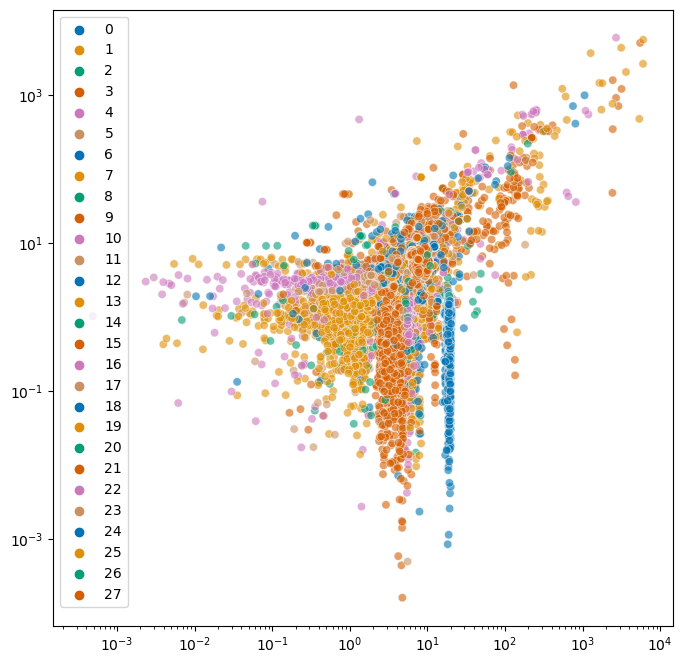

----------------------------------------------------------------------------------------------------
euclidean 260 0.7000000000000001


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


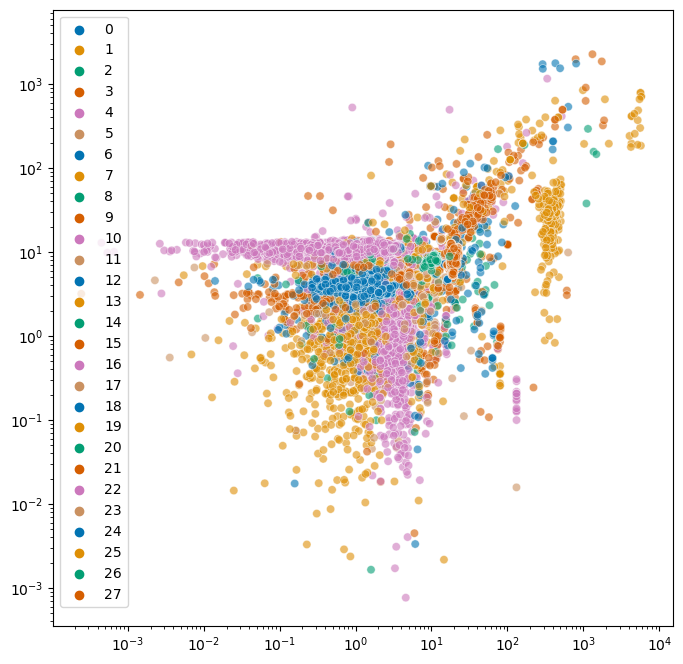

----------------------------------------------------------------------------------------------------
euclidean 280 0.1


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


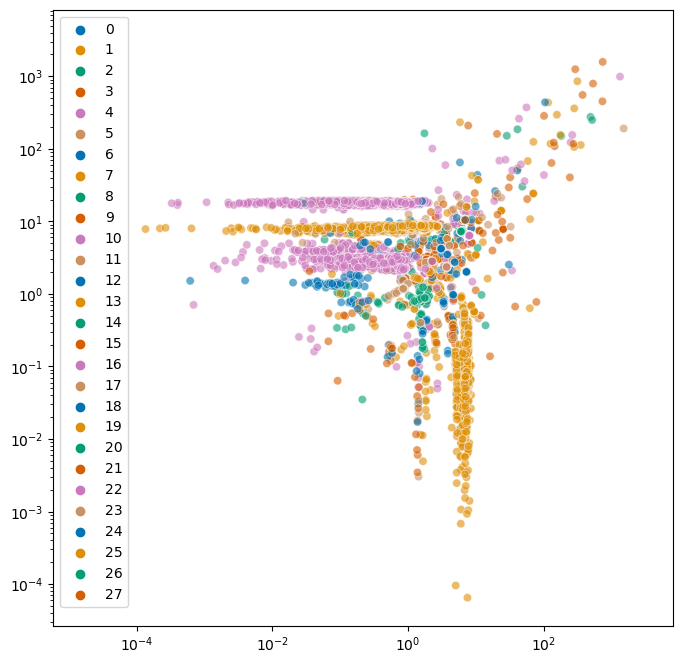

----------------------------------------------------------------------------------------------------
euclidean 280 0.4


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


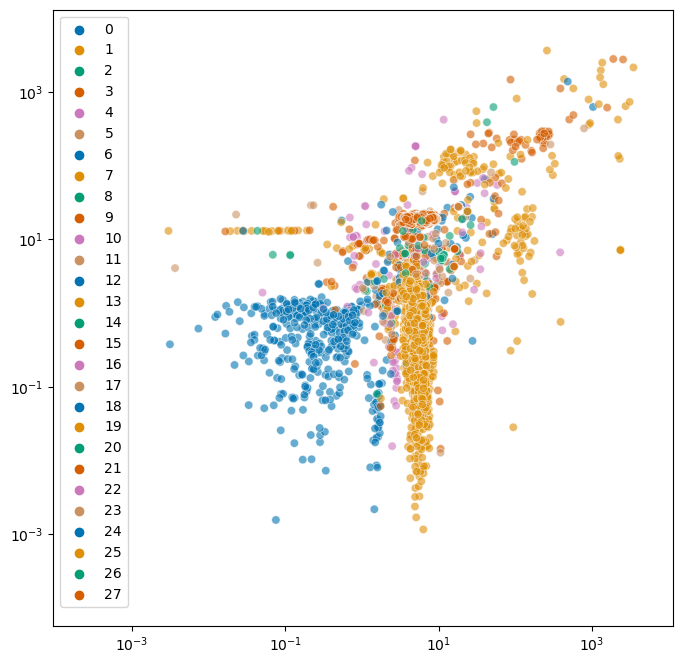

----------------------------------------------------------------------------------------------------
euclidean 280 0.7000000000000001


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


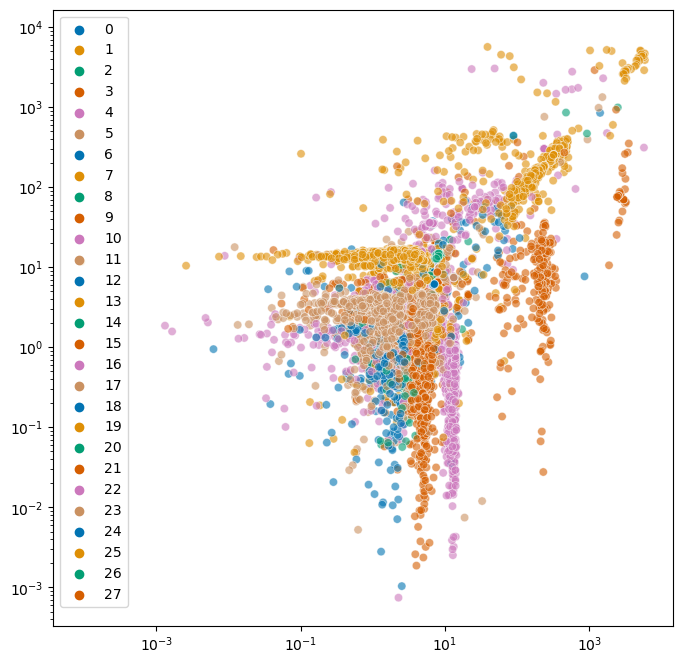

----------------------------------------------------------------------------------------------------
euclidean 300 0.1


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


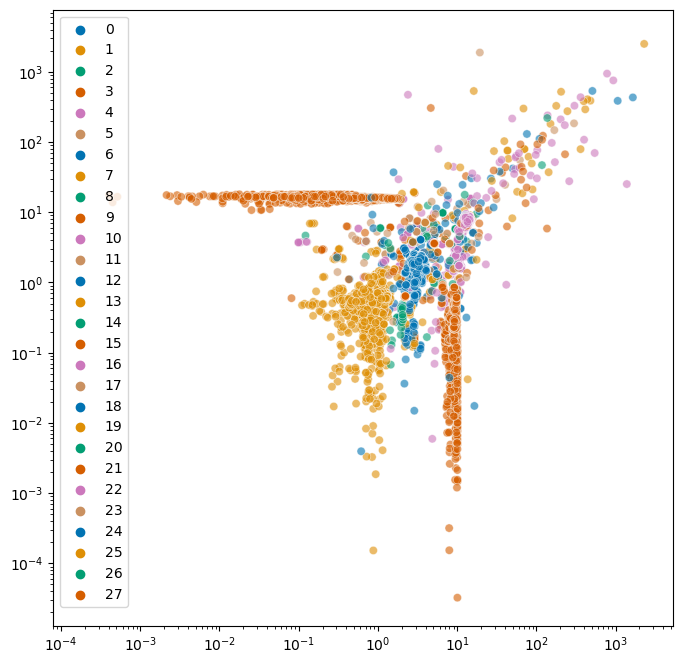

----------------------------------------------------------------------------------------------------
euclidean 300 0.4


/tmp/ipykernel_1718/2808710841.py:18: UserWarning: 
The palette list has fewer values (6) than needed (28) and will cycle, which may produce an uninterpretable plot.
  grid = sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue=ys, ax=ax, palette=color,alpha=0.6)


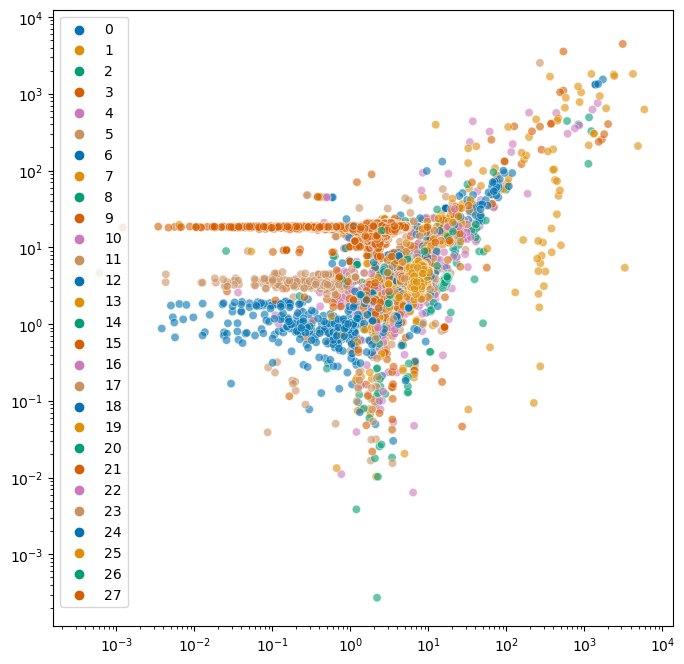

KeyboardInterrupt: 

In [91]:
%%time
umap_combination_unsupervised(xs,ys , dist_list ,  n_neighbor_list , np.arange(0.1 , 1.0 , 0.3) , True, (8,8) , './img' )